In [1]:
import html
import numpy as np
import re
from convokit import Corpus, download
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import json
import spacy
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay,
    cohen_kappa_score
)
import krippendorff
import random


nlp = spacy.load("en_core_web_sm")


from sklearn.metrics import cohen_kappa_score
import krippendorff


def get_cohens_kappa(json_data, df):
    y_true, y_pred = [], []

    for key, entry in json_data["data"].items():
        idx = int(key) - 1
        gold = str(df.loc[idx, "isOthering"]).strip().lower()
        pred = str(entry["annotation"]["label"]).strip().lower()
        y_true.append(gold)
        y_pred.append(pred)

    return cohen_kappa_score(y_true, y_pred)


def krippendorff_alpha(json_data, df):
    y_true, y_pred = [], []

    for key, entry in json_data["data"].items():
        idx = int(key) - 1
        gold = str(df.loc[idx, "isOthering"]).strip().lower()
        pred = str(entry["annotation"]["label"]).strip().lower()
        y_true.append(gold)
        y_pred.append(pred)

    data = [y_true, y_pred]  # rows = annotators, cols = items
    return krippendorff.alpha(reliability_data=data, level_of_measurement="nominal")


# Method definitions
def load_dataset_dynamic(corpus, start_index, end_index):
    return Corpus(
        filename=download(corpus),
        backend="mem",
        utterance_start_index=start_index,
        utterance_end_index=end_index,
    )


def load_dataset_to_memory(corpus_path):
    return Corpus(filename=corpus_path, backend="mem")


def get_target_ids(corpus):
    target_ids = []

    othering_terms = [
        # Dehumanizing terms (animals, pests, disease metaphors)
        "animal",
        "beast",
        "savage",
        "barbaric",
        "subhuman",
        "primitive",
        "parasite",
        "vermin",
        "rat",
        "cockroach",
        "monster",
        "brute",
        "ape",
        "gorilla",
        "monkey",
        "dog",
        "pig",
        "swine",
        "goat",
        "bug",
        "leech",
        "tick",
        "lice",
        "maggot",
        "worm",
        "cancer",
        "tumor",
        "virus",
        "plague",
        "infection",
        "disease",
        # Moral judgment / worthlessness
        "scum",
        "trash",
        "filth",
        "worthless",
        "inferior",
        "degenerate",
        "lowlife",
        "unworthy",
        "unclean",
        "impure",
        "corrupt",
        "dirty",
        "disgusting",
        "vile",
        "evil",
        "wicked",
        "sinful",
        "cursed",
        "burden",
        "freeloader",
        "sponger",
        # Threatening / dangerous
        "dangerous",
        "violent",
        "aggressive",
        "hostile",
        "criminal",
        "thug",
        "deviant",
        "radical",
        "extremist",
        "fundamentalist",
        "terrorist",
        "predator",
        "rapist",
        "gangster",
        "invader",
        "occupier",
        "conqueror",
        "infiltrator",
        "threat",
        # Exclusion / separation
        "outsider",
        "intruder",
        "alien",
        "stranger",
        "foreigner",
        "enemy",
        "unwelcome",
        "illegal",
        "unwanted",
        "expat",
        "outcast",
        "undesirable",
        "colonizer",
        "settler",
        # Diminishing / infantilizing
        "ignorant",
        "backward",
        "naive",
        "uncivilized",
        "helpless",
        "weak",
        "stupid",
        "lazy",
        "immature",
        "childlike",
        "silly",
        "emotional",
        "hysterical",
        "irrational",
        "clueless",
        "brainwashed",
        "sheep",
        "puppet",
        "follower",
        # Religion & secular identities
        "atheists",
        "non-believers",
        "secular people",
        "buddhists",
        "buddhist people",
        "hindus",
        "hindu people",
        "christians",
        "christian people",
        "catholics",
        "protestants",
        "mormons",
        "evangelicals",
        "pagans",
        "satanists",
        "muslims",
        "islamic people",
        "islamists",
        "muzzies",
        "ragheads",
        "jews",
        "jewish people",
        "zionists",
        "orthodox jews",
        # Migration / nationality
        "immigrants",
        "migrants",
        "foreigners",
        "outsiders",
        "refugees",
        "asylum seekers",
        "expats",
        "nationals",
        "illegal aliens",
        "illegals",
        "invaders",
        "colonizers",
        "settlers",
        # Gender & women
        "women",
        "woman",
        "girl",
        "girls",
        "females",
        "ladies",
        "wives",
        "mothers",
        "bitches",
        "sluts",
        "whores",
        "feminists",
        "feminazis",
        # LGBTQ+
        "lgbtq",
        "gay",
        "gays",
        "lesbian",
        "lesbians",
        "bisexual",
        "transgender",
        "trans",
        "tranny",
        "trannies",
        "queer",
        "queers",
        "dyke",
        "dykes",
        "faggot",
        "faggots",
        "non-binary",
        "drag queens",
        "drag kings",
    ]

    # Pre-compile regex patterns
    patterns = [
        re.compile(r"(?i)(?<!\w)" + re.escape(term) + r"(?!\w)")
        for term in othering_terms
    ]

    for utt in corpus.iter_utterances():
        if not utt.text:  # skip empty text
            continue

        # Count words
        word_count = len(utt.text.split())

        if word_count < 100 and any(p.search(utt.text) for p in patterns):
            target_ids.append(utt.id)

    return target_ids


def get_id_chain(corpus, target_id):
    chain = []
    utt = corpus.get_utterance(target_id)
    while utt is not None:
        chain.append(utt)
        utt = corpus.get_utterance(utt.reply_to) if utt.reply_to else None

    # reverse so it's from root → target
    chain = chain[::-1]
    return chain


def plot_wordcloud(chain, title):
    all_words = " ".join(u.text for u in chain).lower()
    wordcloud = WordCloud(
        width=800, height=400, background_color="white", stopwords=STOPWORDS
    ).generate(all_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()


def export_comments_to_json(corpus, target_ids, filepath):
    """
    Export selected comments into JSON format:
    one big JSON object with numeric keys.
    """
    results = {}

    for idx, target_id in enumerate(target_ids, start=1):
        utt = corpus.get_utterance(target_id)
        if utt is None:
            continue

        # build id chain
        id_chain = []
        for i in get_id_chain(corpus, target_id):
            id_chain.append({"id": i.id})

        # get up to 3 preceding comments
        last_idx = len(id_chain) - 1
        start = max(0, last_idx - 3)
        end = last_idx
        context_ids = id_chain[start:end]

        # collect context text
        context_text = []
        for entry in context_ids:
            ctx_utt = corpus.get_utterance(entry["id"])
            if ctx_utt and ctx_utt.text:
                context_text.append(ctx_utt.text)

        # extract top keywords from context
        context = categorize_chunks(" ".join(context_text), top_n=10)

        # build record
        record = {
            "id": target_id,
            "text": getattr(utt, "text", None),
            "timestamp": getattr(utt, "timestamp", None),
            "conversation_id": getattr(utt, "conversation_id", None),
            "comment_chain": id_chain,
            "context": context,
        }
        results[idx] = record  # numeric keys

    # save to JSON
    with open(filepath, "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2, ensure_ascii=False)

    print(f"✅ Saved {len(results)} comments to {filepath} (JSON format)")


def export_comments_to_jsonl(corpus, target_ids, filepath):
    """
    Export selected comments into JSONL format:
    one JSON object per line.
    """
    count = 0
    with open(filepath, "w", encoding="utf-8") as f:
        for target_id in target_ids:
            utt = corpus.get_utterance(target_id)
            if utt is None:
                continue

            id_chain = []
            context = []

            for i in get_id_chain(corpus, target_id):
                id_chain.append({"id": i.id})

            last_idx = len(id_chain) - 1
            start = max(0, last_idx - 3)  # up to 3 preceding comments
            end = last_idx
            context_ids = id_chain[start:end]

            context_text = []
            for id in context_ids:
                context_text.append(corpus.get_utterance(id["id"]).text)

            context = categorize_chunks(" ".join(context_text), top_n=10)

            record = {
                "id": target_id,
                "text": getattr(utt, "text", None),
                "timestamp": getattr(utt, "timestamp", None),
                "conversation_id": getattr(utt, "conversation_id", None),
                "comment_chain": id_chain,
                "context": context,
            }
            f.write(json.dumps(record, ensure_ascii=False) + "\n")
            count += 1

    print(f"✅ Saved {count} comments to {filepath} (JSONL format)")


def categorize_chunks(text, top_n=10):
    doc = nlp(text)

    # collect candidate words/phrases
    candidates = []
    for chunk in doc.noun_chunks:
        phrase = chunk.text.lower().strip()
        if not all(token.is_stop for token in chunk):  # skip only-stopword chunks
            candidates.append(phrase)

    # deduplicate while preserving order
    seen, keywords = set(), []
    for c in candidates:
        if c not in seen:
            seen.add(c)
            keywords.append(c)

    return keywords[:top_n]


def clean_text(text: str) -> str:
    # Collapse multiple newlines into one space
    text = re.sub(r"\s*\n\s*", " ", text)
    # Collapse multiple spaces
    text = re.sub(r"\s+", " ", text)
    return text.strip()


def clean_links(text: str, keep_anchor=True):
    # Remove markdown-style links [text](url)
    if keep_anchor:
        return re.sub(r"\[([^\]]+)\]\([^)]+\)", r"\1", text)
    else:
        return re.sub(r"\[([^\]]+)\]\([^)]+\)", "[URL]", text)


def clean_html_tags(text: str) -> str:
    return html.unescape(text)

c:\Users\hofin\anaconda3\envs\bachelor_thesis\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


TransformerDecoderModel requires ML dependencies. Run 'pip install convokit[llm]' to install them.
UnslothUtteranceSimulatorModel requires ML dependencies. Run 'pip install convokit[llm]' to install them.


Counts:
Gold - Othering: 66
Gold - None: 34
Predicted - Othering: 75
Predicted - None: 25

Classification Report:
              precision    recall  f1-score   support

    Othering       0.84      0.62      0.71        34
        None       0.83      0.94      0.88        66

    accuracy                           0.83       100
   macro avg       0.83      0.78      0.80       100
weighted avg       0.83      0.83      0.82       100



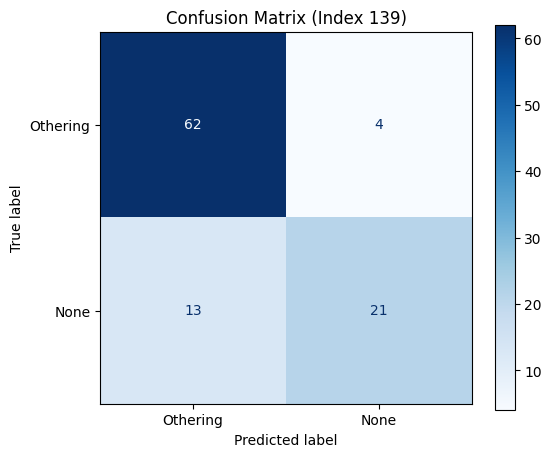


Misclassified Cases:

Index: 7
Text: Every women is a potential child killer.
Gold Label: None
Predicted Label: Othering

Index: 8
Text: First you get the sugar. Then you get the power. Then you get the woman.
Gold Label: None
Predicted Label: Othering

Index: 31
Text: Lol wow the media really brainwashed you folks. It is shitty in the Arab world but not close to what you have been shown. Kuwait is not Afghanistan for fuck's sake.
Gold Label: None
Predicted Label: Othering

Index: 39
Text: You might want to spread that word to a lot of other fellow Christians. 
Gold Label: None
Predicted Label: Othering

Index: 41
Text: Where in the world is history NOT massively whitewashed? China? Russia? Africa? South America? It happens everywhere. And not mentioning many of the great women in the history of various cultures as they do their male counterparts? Sadly it is something that has happened for centuries all over the place.
Gold Label: None
Predicted Label: Othering

Index: 44
Text: He's 

In [12]:
os.chdir(
    r"C:\Users\hofin\OneDrive - Fachhochschule St. Pölten\__BachelorThesis\blast_othering"
)

CURRENT_INDEX = 139

df = pd.read_excel("Annotaions_Niklas.xlsx", sheet_name="Tabelle3")

with open(
    f"data/results/{CURRENT_INDEX}/stage_8_results_{CURRENT_INDEX}_high_temp.json",
    "r",
    encoding="utf-8",
) as f:
    data = json.load(f)

predicted_labels = [v["annotation"]["label"] for v in data["data"].values()]
gold_labels = (
    df.iloc[:, 1].replace({"Yes": "Othering", "No": "None"}).astype(str).tolist()
)

gold_labels = [x if x in ["Othering", "None"] else "None" for x in gold_labels]
predicted_labels = [
    x if x in ["Othering", "None"] else "None" for x in predicted_labels
]

# Sort JSON items by numeric key
json_items = sorted(data["data"].items(), key=lambda x: int(x[0]))

# Create a lookup dictionary for predictions
pred_dict = {
    int(k): (
        v["annotation"]["label"].strip().capitalize()
        if isinstance(v["annotation"]["label"], str)
        else "None"
    )
    for k, v in json_items
}

# Default any missing indices to "None"
predicted_labels = [
    pred_dict.get(i + 1, "None")  # assumes Excel starts at index 1
    for i in range(len(gold_labels))
]

# Normalize labels
predicted_labels = [
    x if x in ["Othering", "None"] else "None" for x in predicted_labels
]

# Align gold labels
gold_labels = (
    df.iloc[:, 1].replace({"Yes": "Othering", "No": "None"}).astype(str).tolist()
)
gold_labels = [x if x in ["Othering", "None"] else "None" for x in gold_labels]
# Counts
print("Counts:")
print(f"Gold - Othering: {gold_labels.count('Othering')}")
print(f"Gold - None: {gold_labels.count('None')}")
print(f"Predicted - Othering: {predicted_labels.count('Othering')}")
print(f"Predicted - None: {predicted_labels.count('None')}")

# Metrics
acc = accuracy_score(gold_labels, predicted_labels)
recall = recall_score(gold_labels, predicted_labels, pos_label="Othering")
precision = precision_score(gold_labels, predicted_labels, pos_label="Othering")
f1 = f1_score(gold_labels, predicted_labels, pos_label="Othering")

# Detailed report
print("\nClassification Report:")
print(
    classification_report(
        gold_labels, predicted_labels, target_names=["Othering", "None"]
    )
)

# Confusion Matrix
cm = confusion_matrix(gold_labels, predicted_labels, labels=["Othering", "None"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Othering", "None"])

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap="Blues", colorbar=True)
plt.title(f"Confusion Matrix (Index {CURRENT_INDEX})")
plt.show()

misclassified = [
    (i, gold, pred) for i, (gold, pred) in enumerate(zip(gold_labels, predicted_labels))
    if gold != pred
]

print("\nMisclassified Cases:")
for idx, gold, pred in misclassified:
    text = df.iloc[idx, 0]  # assuming first column contains the text/comment
    print(f"\nIndex: {idx}")
    print(f"Text: {text}")
    print(f"Gold Label: {gold}")
    print(f"Predicted Label: {pred}")

# --- Cohen's Kappa ---
kappa = cohen_kappa_score(gold_labels, predicted_labels)
print(f"\nCohen's Kappa: {kappa:.3f}")

# --- Krippendorff's Alpha ---
# Krippendorff expects a reliability data matrix, so we reshape labels
# Convert "Othering" → 1, "None" → 0
mapping = {"Othering": 1, "None": 0}
gold_numeric = [mapping[g] for g in gold_labels]
pred_numeric = [mapping[p] for p in predicted_labels]

alpha = krippendorff.alpha(reliability_data=[gold_numeric, pred_numeric], level_of_measurement='nominal')
print(f"Krippendorff's Alpha: {alpha:.3f}")

In [4]:
import json
from collections import Counter
import statistics

# Paths to your 3 temperature runs
files = [
    f"data/results/{CURRENT_INDEX}/stage_8_results_{CURRENT_INDEX}_low_temp.json",
    f"data/results/{CURRENT_INDEX}/stage_8_results_{CURRENT_INDEX}_medium_temp.json",
    f"data/results/{CURRENT_INDEX}/stage_8_results_{CURRENT_INDEX}_high_temp.json"
]

# Load all
runs = [json.load(open(f))["data"] for f in files]

# Assume all have same doc IDs
doc_ids = runs[0].keys()
final_results = {}

for doc_id in doc_ids:
    labels = []
    scores = []
    reasonings = []
    targets = []

    for run in runs:
        ann = run[doc_id].get("annotation", {})
        if not ann: continue
        labels.append(ann.get("label", "").strip())
        if ann.get("score") is not None:
            scores.append(float(ann["score"]))
        reasonings.append(ann.get("reasoning", ""))
        targets.append(ann.get("target", ""))

    if not labels:
        continue

    # Majority vote
    final_label, votes = Counter(labels).most_common(1)[0]
    agreement = votes / len(labels)

    # Average confidence
    avg_score = statistics.mean(scores) if scores else None

    # Optional: most common target
    target_counter = Counter([t for t in targets if t])
    final_target = target_counter.most_common(1)[0][0] if target_counter else None

    final_results[doc_id] = {
        "text": runs[0][doc_id]["text"],
        "label": final_label,
        "agreement": round(agreement, 2),
        "avg_score": round(avg_score, 3) if avg_score else None,
        "votes": labels,
        "reasonings": reasonings,
        "final_target": final_target
    }

# Save the merged output
with open(f"data/results/{CURRENT_INDEX}/stage_8_results_{CURRENT_INDEX}_merged.json", "w") as f:
    json.dump(final_results, f, indent=2)

print("Merged annotations saved to results/stage_8_results_001_merged.json")

FileNotFoundError: [Errno 2] No such file or directory: 'data/results/119/stage_8_results_119_low_temp.json'

In [ ]:
# import json

# # === INPUT / OUTPUT FILE PATHS ===
# input_path = "./data_collection/exported_comments.json"     # your large input file
# output_path = "./data/annotations_1000.json"  # your new output file

# # === LOAD FULL DATASET ===
# with open(input_path, "r", encoding="utf-8") as f:
#     data = json.load(f)

# # === EXTRACT FIRST 1000 COMMENTS ===
# subset = {}
# for i, (key, value) in enumerate(data.items()):
#     if i >= 1000:
#         break
#     subset[str(i + 1)] = {"text": value["text"]}

# # === SAVE TO NEW FILE ===
# with open(output_path, "w", encoding="utf-8") as f:
#     json.dump(subset, f, indent=4, ensure_ascii=False)

# print(f"✅ Saved first {len(subset)} comments to {output_path}")

✅ Saved first 1000 comments to ./data/annotations_1000.json


In [47]:
import json
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report

CURRENT_INDEX = 116

# Load gold labels
df = pd.read_excel("Annotaions_Niklas.xlsx", sheet_name="Tabelle3")

# Convert Excel annotations to standardized form
gold_labels = (
    df.iloc[:, 1].replace({"Yes": "Othering", "No": "None"}).astype(str).tolist()
)
gold_labels = [x if x in ["Othering", "None"] else "None" for x in gold_labels]

# Load predicted data
with open(
    f"data/results/{CURRENT_INDEX}/stage_8_results_{CURRENT_INDEX}_merged.json",
    "r",
    encoding="utf-8",
) as f:
    data = json.load(f)

correct = []
unsure_correct = []

for id_str in data:
    idx = int(id_str) - 1  

    if idx >= len(gold_labels):
        continue

    agreement = float(data[id_str].get('agreement', 0))
    pred_label = data[id_str].get('final_label', data[id_str].get('label', 'None'))
    gold_label = gold_labels[idx]

    if agreement == 1.0:
        if pred_label == gold_label:
            correct.append(True)
        else:
            correct.append(False)
            #print(f"❌ ID {id_str}: Pred={pred_label}, Gold={gold_label}")
    elif agreement != 1.0:
        if pred_label == gold_label:
            unsure_correct.append(True)
        else:
            unsure_correct.append(False)
            print(f"❌ ID {id_str}: Pred={pred_label}, Gold={gold_label}")
            
print(unsure_correct.count(True))
print(unsure_correct.count(False))


❌ ID 1: Pred=Othering, Gold=None
❌ ID 44: Pred=Othering, Gold=None
❌ ID 98: Pred=Othering, Gold=None
2
3


In [5]:
# --- Setup ---
os.chdir(
    r"C:\Users\hofin\OneDrive - Fachhochschule St. Pölten\__BachelorThesis\blast_othering"
)

CURRENT_INDEX = 119

# Load gold labels from Excel
df = pd.read_excel("Annotaions_Niklas.xlsx", sheet_name="Tabelle3")
gold_labels = (
    df.iloc[:, 1].replace({"Yes": "Othering", "No": "None"}).astype(str).tolist()
)
gold_labels = [x if x in ["Othering", "None"] else "None" for x in gold_labels]

# Load predictions from new JSON structure
with open(
    f"data/results/{CURRENT_INDEX}/stage_8_results_{CURRENT_INDEX}_merged.json",
    "r",
    encoding="utf-8",
) as f:
    data = json.load(f)

# --- Extract predicted labels (flat structure, no 'annotation' nesting) ---
# Sort by numeric key to ensure correct order
json_items = sorted(data.items(), key=lambda x: int(x[0]))

pred_dict = {
    int(k): (
        v.get("label", "None").strip().capitalize()
        if isinstance(v.get("label"), str)
        else "None"
    )
    for k, v in json_items
}

# Default any missing indices to "None"
predicted_labels = [
    pred_dict.get(i + 1, "None")  # assumes Excel rows start at index 1
    for i in range(len(gold_labels))
]

# Normalize predicted labels
predicted_labels = [
    x if x in ["Othering", "None"] else "None" for x in predicted_labels
]

# --- Counts ---
print("Counts:")
print(f"Gold - Othering: {gold_labels.count('Othering')}")
print(f"Gold - None: {gold_labels.count('None')}")
print(f"Predicted - Othering: {predicted_labels.count('Othering')}")
print(f"Predicted - None: {predicted_labels.count('None')}")

# --- Metrics ---
acc = accuracy_score(gold_labels, predicted_labels)
recall = recall_score(gold_labels, predicted_labels, pos_label="Othering")
precision = precision_score(gold_labels, predicted_labels, pos_label="Othering")
f1 = f1_score(gold_labels, predicted_labels, pos_label="Othering")

print("\nClassification Report:")
print(
    classification_report(
        gold_labels, predicted_labels, target_names=["Othering", "None"]
    )
)

# --- Confusion Matrix ---
cm = confusion_matrix(gold_labels, predicted_labels, labels=["Othering", "None"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Othering", "None"])
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap="Blues", colorbar=True)
plt.title(f"Confusion Matrix (Index {CURRENT_INDEX})")
plt.show()

# --- Misclassified Cases ---
misclassified = [
    (i, gold, pred) for i, (gold, pred) in enumerate(zip(gold_labels, predicted_labels))
    if gold != pred
]

print("\nMisclassified Cases:")
for idx, gold, pred in misclassified:
    text = df.iloc[idx, 0]  # assuming 1st column is the text/comment
    print(f"\nIndex: {idx}")
    print(f"Text: {text}")
    print(f"Gold Label: {gold}")
    print(f"Predicted Label: {pred}")

# --- Cohen's Kappa ---
kappa = cohen_kappa_score(gold_labels, predicted_labels)
print(f"\nCohen's Kappa: {kappa:.3f}")

# --- Krippendorff's Alpha ---
mapping = {"Othering": 1, "None": 0}
gold_numeric = [mapping[g] for g in gold_labels]
pred_numeric = [mapping[p] for p in predicted_labels]
alpha = krippendorff.alpha(
    reliability_data=[gold_numeric, pred_numeric], level_of_measurement='nominal'
)
print(f"Krippendorff's Alpha: {alpha:.3f}")

FileNotFoundError: [Errno 2] No such file or directory: 'data/results/119/stage_8_results_119_merged.json'

In [ ]:
os.chdir(
    r"C:\Users\hofin\OneDrive - Fachhochschule St. Pölten\__BachelorThesis\blast_othering"
)

with open(
    f"data/results/120/stage_7_results_120.json",
    "r",
    encoding="utf-8",
) as f:
    target_data = json.load(f)

with open(
    f"data/annotations_1000.json",
    "r",
    encoding="utf-8",
) as f:
    ann_data = json.load(f)
    
with open(
    f"data/results/120/stage_8_results_120_high_temp.json",
    "r",
    encoding="utf-8",
) as f:
    data = json.load(f)


isSocialGroup = []
isSocialGroupFalseIds = []

for id, entry in target_data["data"].items():
    isSocialGroup.append(entry["annotation"]["isSocialGroup"])

    if entry["annotation"]["isSocialGroup"] == False:
        isSocialGroupFalseIds.append(id)

new_data = {}

for id in isSocialGroupFalseIds:
    id_str = str(id)  # ensure it's a string key
    if id_str in ann_data:
        text = ann_data[id_str]["text"]
        new_data[id_str] = {
            "text": text,
            "annotation": {"label": "None", "reasoning": "No real social group found."},
        }
        
output_path = "data/results/120/isSocialGroupFalse.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(new_data, f, ensure_ascii=False, indent=4)

data_only = data["data"]

# Optionally save it to a new JSON file
output_path = r"data/results/120/stage_8_results_120_high_temp_data_only.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(data_only, f, ensure_ascii=False, indent=4)

print(f"Saved data-only JSON to: {output_path}")

with open(
    f"data/results/120/stage_8_results_120_high_temp_data_only.json",
    "r",
    encoding="utf-8",
) as f:
    data1 = json.load(f)

with open(
    f"data/results/120/isSocialGroupFalse.json",
    "r",
    encoding="utf-8",
) as f:
    data2 = json.load(f)
    
combined = {**data1, **data2}
output_path = "data/results/120/combined_data.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(combined, f, ensure_ascii=False, indent=4)


with open("data/results/120/combined_data.json", "r", encoding="utf-8") as f:
    combined = json.load(f)

# Sort by numeric ID
sorted_combined = dict(sorted(combined.items(), key=lambda x: int(x[0])))

# Save sorted JSON
output_path = "data/results/120/combined_data_sorted.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(sorted_combined, f, ensure_ascii=False, indent=4)

print(f"✅ Saved sorted JSON by ID to {output_path}")

✅ Saved sorted JSON by ID to data/results/120/combined_data_sorted.json


In [49]:
with open(
    "data/results/120/combined_data_sorted.json",
    "r",
    encoding="utf-8",
) as f:
    data = json.load(f)

# The keys are strings like "1", "2", "3", ...
rand_key = random.choice(list(data.keys()))
random_item = data[rand_key]

print(f"ID: {rand_key}")
print(f"Text: {random_item['text']}")
print(f"Label: {random_item['annotation']['label']}")


ID: 213
Text: Yeah, of course there are. But what are the chances that 75% of the officers that came to his room are cute females? The cherry on top is that he gets his rocks off to that. Just sounds fishy to me.
Label: Othering


In [11]:
os.chdir(
    r"C:\Users\hofin\OneDrive - Fachhochschule St. Pölten\__BachelorThesis\blast_othering"
)

CURRENT_INDEX = 97

df = pd.read_excel("Annotaions_Niklas.xlsx", sheet_name="Tabelle3")

with open(
    f"data/results/{CURRENT_INDEX}/6_target_results_{CURRENT_INDEX}.json",
    "r",
    encoding="utf-8",
) as f:
    data = json.load(f)

# Sort the data["data"] dictionary by numeric key
sorted_data = dict(sorted(data["data"].items(), key=lambda x: int(x[0])))

# Extract predicted targets in order
predicted_labels = [
    str(v["annotation"].get("target", "")).strip().lower()
    for v in sorted_data.values()
]

# Extract gold targets, skip header row if necessary
gold_labels = (
    df.iloc[:, 3]  # skip header if needed
    .astype(str)
    .str.strip()
    .str.lower()
    .tolist()
)

# Sanity check for lengths
print(f"\nTotal Predicted: {len(predicted_labels)} | Total Gold: {len(gold_labels)}")

print("🔎 Mismatched cases (Predicted ≠ Gold):\n")
for i, (pred, gold) in enumerate(zip(predicted_labels, gold_labels), start=1):
    if pred != gold:
        print(f"{i:03d}. Predicted: {pred:<25} | Gold: {gold}")


Total Predicted: 100 | Total Gold: 100
🔎 Mismatched cases (Predicted ≠ Gold):

001. Predicted: young kids                | Gold: people from this sub
002. Predicted: women                     | Gold: men
007. Predicted: minors                    | Gold: catholic priests
008. Predicted: women                     | Gold: woman
009. Predicted: women                     | Gold: woman
010. Predicted: christians                | Gold: christianity
013. Predicted: people who read all their texts | Gold: people who read all the texts
017. Predicted: gay men                   | Gold: gay
024. Predicted: ugly girls                | Gold: girls
025. Predicted: foreign immigrants        | Gold: immigrants
030. Predicted: christians                | Gold: christianity
032. Predicted: arabs                     | Gold: no group
033. Predicted: men                       | Gold: us
034. Predicted: american men, specifically those who hunt and are perceived as aggressive or violent | Gold: american men

In [3]:
corpus = load_dataset_dynamic("reddit-corpus-small", 0, 10000)
target_ids = get_target_ids(corpus)

# for target_id in target_ids:
#     chain = get_id_chain(corpus, target_id)
#     for u in chain:
#         print(f"{u.id}")
#     print("-----")

# print(target_ids)

Dataset already exists at C:\Users\hofin\.convokit\saved-corpora\reddit-corpus-small


In [ ]:
import os

# target_ids = get_target_ids(corpus)

os.chdir(
    r"C:\Users\hofin\OneDrive - Fachhochschule St. Pölten\__BachelorThesis\blast_othering"
)


export_comments_to_json(corpus, target_ids, "data_collection/reddit-corpus-small.json")

✅ Saved 17532 comments to data_collection/reddit-corpus-small.json (JSON format)


In [ ]:
os.chdir(
    r"C:\Users\hofin\OneDrive - Fachhochschule St. Pölten\__BachelorThesis\blast_othering"
)

with open("data_collection/reddit-corpus-small.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# keep only the first `limit` items
sliced = {k: data[k] for k in list(data.keys())[:100]}

with open("data_collection/reddit-corpus-small-100.json", "w", encoding="utf-8") as f:
    json.dump(sliced, f, indent=2, ensure_ascii=False)

print(f"✅ Saved first {len(sliced)}")

✅ Saved first 100


In [ ]:
with open("data_collection/reddit-corpus-small-100.json", "r", encoding="utf-8") as f:
    data = json.load(f)

for key in data:
    data[key]["text"] = clean_text(data[key]["text"])
    data[key]["text"] = clean_links(data[key]["text"])
    data[key]["text"] = clean_html_tags(data[key]["text"])

with open("data_collection/reddit-corpus-small-100.json", "w", encoding="utf-8") as f:
    json.dump(data, f, indent=2, ensure_ascii=False)

In [ ]:
with open("data_collection/reddit-corpus-small-100.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert dict-of-dicts into a list of records
records = []
for key, value in data.items():
    record = {"id": key}
    record.update(value)
    records.append(record)

# Convert to DataFrame
df = pd.DataFrame(records)

# Save to Excel
df.to_excel("reddit_corpus.xlsx", index=False)
print("✅ Saved JSON to reddit_corpus.xlsx")

✅ Saved JSON to reddit_corpus.xlsx


Cohens Kappa: 0.670510708401977
Krippendorff's Alpha: 0.6654056326187474


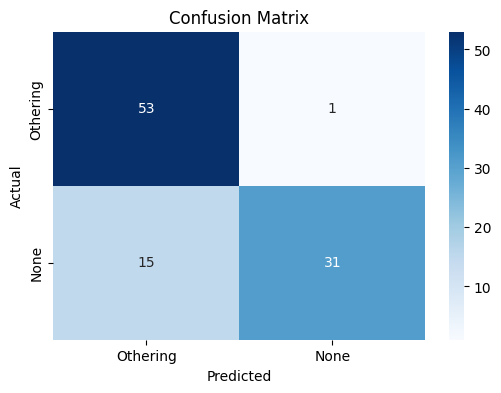

In [ ]:
os.chdir(
    r"C:\Users\hofin\OneDrive - Fachhochschule St. Pölten\__BachelorThesis\blast_othering"
)

with open("data/results/82/stage_6_results_82.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.read_excel("examples.xlsx", sheet_name="Tabelle2")
df = df.replace({np.nan: "None"})
df = df.replace({"No": "None"})
excel_othering = df["isOthering"].astype(str).tolist()

print(f"Cohens Kappa: {get_cohens_kappa(data, df)}")
print(f"Krippendorff's Alpha: {krippendorff_alpha(data, df)}")

y_true, y_pred = [], []

for key, entry in data["data"].items():
    idx = int(key) - 1
    gold = str(df.loc[idx, "isOthering"]).strip().lower()
    pred = str(entry["annotation"]["label"]).strip().lower()
    y_true.append(gold)
    y_pred.append(pred)

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=["othering", "none"])

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Othering", "None"],
    yticklabels=["Othering", "None"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
os.chdir(
    r"C:\Users\hofin\OneDrive - Fachhochschule St. Pölten\__BachelorThesis\blast_othering"
)

# Load JSON manually
with open("./data_collection/reddit-corpus-small.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert dict-of-dicts into DataFrame
df = pd.DataFrame.from_dict(data, orient="index")

# Check what columns exist
print(df.columns)

# If "id" and "text" exist, select them
if "id" in df.columns and "text" in df.columns:
    df_small = df[["id", "text"]]
else:
    # Some nested dicts may be inside, so force-safe extraction
    df_small = df.apply(
        lambda row: pd.Series({"id": row.get("id"), "text": row.get("text")}), axis=1
    )

# Optional: limit rows
df_small_sliced = df_small.head(10000)

# Save to Excel
df_small_sliced.to_excel("corpus-small-sliced.xlsx", index=False)

Index(['id', 'text', 'timestamp', 'conversation_id', 'comment_chain',
       'context'],
      dtype='object')
